# Text Analytics Seminar - Hands-on Session on Active Learning
The purpose of this session is to experiment with baseline active learing approaches and compare the results. To reduce runtime, this session simply uses a linear support vector machine without any big hyperparameter tuning. Our main objective is to compare different active learning approaches against each other and analyze the learning curves.

### General Set up

First, we import all required modules and define the configuration for training our model:

In [1]:
import argparse
import sys
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import data_processing as dp

config = {
    'embedding':'embedding/glove.6B.50d.subset.oov.vec',
    'train':'data/train.tsv',
    'dev':'data/dev.tsv',
    'test':'data/test.tsv'
}

Now load our data in the appropriate format:

In [2]:
###########################################
#       Loading data and vectors
###########################################
    
# Load our pre-trained word embedding
embedding,embed_dim = dp.load_word2vec_embedding(config['embedding'])

# Load our training set, dev set, and test set
X_train, y_train = dp.load_data(config['train'], textindex=1, labelindex=0)
X_dev, y_dev = dp.load_data(config['dev'], textindex=1, labelindex=0)
X_test, y_test = dp.load_data(config['test'], textindex=1, labelindex=0)

# Get index-word/label dicts for lookup:
vocab_dict = dp.get_index_dict(X_train + X_dev + X_test)

# Replace words / labels in the data by the according index
vocab_dict_flipped = dict((v,k) for k,v in vocab_dict.items())

# Get indexed data and labels
X_train_index = [[vocab_dict_flipped[word] for word in chunk] for chunk in X_train]
X_dev_index =  [[vocab_dict_flipped[word] for word in chunk] for chunk in X_dev]
X_test_index =  [[vocab_dict_flipped[word] for word in chunk] for chunk in X_test]

# Get embedding matrix:
embed_matrix = dp.get_embedding_matrix(embedding,vocab_dict)

# Use the simple count over all features in a single example:
# Do average over word vectors:
X_train_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_train_index]
X_dev_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_dev_index]
X_test_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_test_index]

print("Loaded data.")

Loaded data.


Finally, we can start training our SVM and tune it's c on the development set! Since we have binary text classification, it is sufficient to use accuracy as our evaluation metric.

In [3]:
# Start training our SVM on the binary classification task (accuracy is enough for evaluation)
# Tune C on the dev set, test on the test set:
best_acc = 0.0
best_c_acc = 0.0

for c in [0.001, 0.01, 0.1, 1, 2, 4, 8, 16, 32, 64, 128, 256]:
    model_svm = SVC(C=c, kernel='linear', probability=True)
    model_svm.fit(X_train_embedded, y_train)

    # Use dev set to tune our hyperparameters
    pred_svm = model_svm.predict(X_dev_embedded)
    true_svm = y_dev

    acc = accuracy_score(true_svm,pred_svm)

    if acc > best_acc:
        best_acc = acc
        best_c_acc = c

print("Best dev score: ", best_acc)

Best dev score:  0.89


At last, we evaluate our tuned model on the test set to get its true performance:

In [4]:
# Test best model on test set
best_model = SVC(C=best_c_acc, kernel='linear', probability=True)
best_model.fit(X_train_embedded, y_train)

best_pred = best_model.predict(X_test_embedded)
test_acc = accuracy_score(y_test,best_pred)

print("Best C: ",best_c_acc)
print("Test score: ",test_acc)

Best C:  2
Test score:  0.89375


### Active Learning Model
Now we modify the model to be able to learn actively. First, we define what we need to configure for testing active learning strategies.

In [18]:
from active_learning import Active_Learning

active_learning_config = {
    'embedding':'embedding/glove.6B.50d.subset.oov.vec',
    'train_labeled':'data/train_labeled.tsv',
    'train_unlabeled':'data/train_unlabeled.tsv',
    'test':'data/test.tsv',
    'sampling':'random', # Sampling strategy, currently implemented ['random', 'confidence']
    'c':2, # C for our SVM
    'seed':42, # Random seed for the pseudo-randomnumber generator
    'maximum_iterations':500, # Maximum number of active learning iterations
    'active_learning_history':'results/svm-al-random.result' # File to store the results in
}

Now load all the required data. Keep in mind that we do not need any development set, since we already tuned our hyperparameters when calculating the upper bound.

In [19]:
embedding,embed_dim = dp.load_word2vec_embedding(active_learning_config['embedding'])

X_train, y_train = dp.load_data(active_learning_config['train_labeled'], textindex=1, labelindex=0)
X_test, y_test = dp.load_data(active_learning_config['test'], textindex=1, labelindex=0)

# Active learning data
X_active, y_active = dp.load_data(active_learning_config['train_unlabeled'], textindex=1, labelindex=0)

# Get index-word/label dicts for lookup:
# NOTE: Creating a dictionary out of all data has the implicit assumption 
#       that all the words we encounter during sampling and testing we have already seen during training.
vocab_dict = dp.get_index_dict(X_train + X_test + X_active) 

# Replace words / labels in the data by the according index
vocab_dict_flipped = dict((v,k) for k,v in vocab_dict.items())

# Get indexed data and labels
X_train_index = [[vocab_dict_flipped[word] for word in chunk] for chunk in X_train]
X_test_index =  [[vocab_dict_flipped[word] for word in chunk] for chunk in X_test]

# Active learning data
X_active_index =  [[vocab_dict_flipped[word] for word in chunk] for chunk in X_active]

print ("Number of initial training documents: ",len(X_train))

# Get embedding matrix:
embed_matrix = dp.get_embedding_matrix(embedding,vocab_dict)

# Use the simple count over all features in a single example:
# Do average over word vectors:
X_train_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_train_index]
X_test_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_test_index]

# Active learning
X_active_embedded = [np.mean([embed_matrix[element] for element in example], axis=0) for example in X_active_index]

# Define our pools for active learning
pool_data = X_active_embedded[:]
pool_labels = y_active[:]

print("Loaded data.")

Number of initial training documents:  2
Loaded data.


After loading all the necessary data, we start doing active learning steps until some stopping criterium.

In [ ]:
# Active learning results for visualization
step, acc = [],[]

iteration = 0

outlog = open(active_learning_config['active_learning_history'],'w')
outlog.write('Iteration\tAccuracy\n')

while len(pool_data) > 1 and iteration < active_learning_config['maximum_iterations']:
    if len(X_train_embedded) % 50 == 0:
        print("Training on: ", len(X_train_embedded), " instances.")

    model_svm = SVC(C=c, kernel='linear', probability=True)
    model_svm.fit(X_train_embedded, y_train)

    pred = model_svm.predict(X_test_embedded)

    test_acc = accuracy_score(y_test,pred)
    
    outlog.write('{}\t{}\n'.format(iteration,test_acc))

    step.append(iteration); acc.append(test_acc)

    # Add data from the pool to the training set based on our active learning:
    al = Active_Learning(pool_data, model_svm, active_learning_config['seed'])
    if active_learning_config['sampling'] == 'random':
        add_sample_data = al.get_random()
    else:
        add_sample_data = al.get_most_uncertain(active_learning_config['sampling'])

    # Get the data index from pool
    sample_index = dp.get_array_index(pool_data, add_sample_data)
        
    # Get the according label
    add_sample_label = pool_labels[sample_index]

    # Add it to the training pool
    X_train_embedded.append(add_sample_data)
    y_train.append(add_sample_label)

    # Remove labeled data from pool
    del pool_labels[sample_index]
    del pool_data[sample_index]

    iteration += 1

outlog.close()

### Visualizing the Learning Curve 
Now visualize the performance of the model with increasing number of examples. How does it look like?

In [ ]:
import visualize as vz

vz.plot(step, acc)

### Comparing Different Strategies
The module active_learning contains the class Active_Learning, which currenty implements a random baseline and least confident sampling. Can you think of other strategies? Try to add them for comparison.

### Visualizing different Learning Curves
To compare different learning curves, pass a list of different result files into the following code snippet. Some default result files are already provided in the 'results' folder. You already precomputed the upper bound in the first part of this exercise, so we should also add this to the plot.

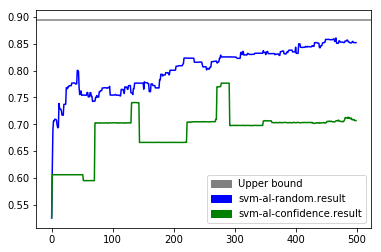

In [25]:
result_files = ['results/svm-al-random.result', 'results/svm-al-confidence.result']
upper_bound = 0.89375
# Read all results
results = [dp.read_active_learning_history(single_file) for single_file in result_files]
# Generate captions
captions = [single_file.split('/')[-1] for single_file in result_files]
# Plot all graphs
vz.plot_several(results, captions, upper_bound)